In [83]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, save_model
from keras.optimizers import Adam

import keras.backend as K
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from json_tricks import dumps, loads
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys

import numpy as np

In [4]:
i = 0
lines = []
# with open("data/data4_valid_mul5/fl4-mul5-comb-new.txt") as f:
with open("/Users/gvsi/Developer/gan-rl/data/data4_monitor_10000x5/comb.txt") as f:
    for line in f:
        lines.append(line)

In [5]:
Qs = []
for i in tqdm(range(len(lines))):
    map_str_comb, dic = lines[i].split("\t")
    obj = loads(dic)
    Qs.append(obj['Q'])

100%|██████████| 3827/3827 [00:19<00:00, 196.04it/s]


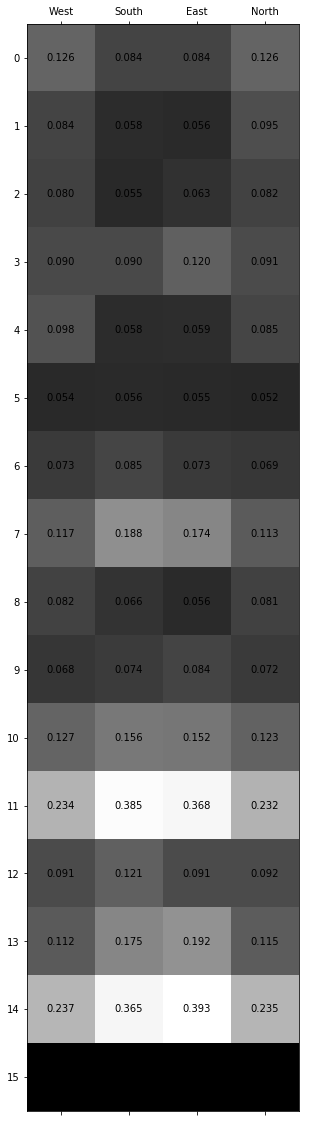

In [6]:
data = pd.DataFrame(np.array([list(q.flatten()) for q in Qs]))
fig, ax = plt.subplots(figsize=(40, 20))

dat = np.array(data.describe().loc['mean']).reshape((16,4))
ax.matshow(dat, cmap='Greys_r')
# ax.set_xticks(np.arange(10), minor=False)
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[0] = 'West'
# labels[1] = 'South'
# labels[2] = 'East'
# labels[3] = 'Up'
# labels[4] = 'North'
# print(labels)
labels = ['','West', 'South', 'East', 'North']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(dat.shape[0]), minor=False)
for (i, j), z in np.ndenumerate(dat):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

# fig.savefig("Qtable_mean.pdf", bbox_inches='tight')

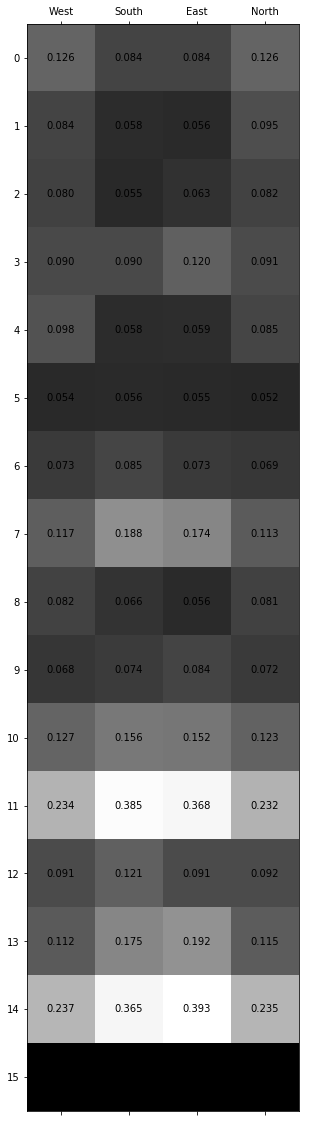

In [7]:
data = pd.DataFrame(np.array([list(q.flatten()) for q in Qs]))
fig, ax = plt.subplots(figsize=(40, 20))

dat = np.array(data.describe().loc['mean']).reshape((16,4))
ax.matshow(dat, cmap='Greys_r')
# ax.set_xticks(np.arange(10), minor=False)
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[0] = 'West'
# labels[1] = 'South'
# labels[2] = 'East'
# labels[3] = 'Up'
# labels[4] = 'North'
# print(labels)
labels = ['','West', 'South', 'East', 'North']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(dat.shape[0]), minor=False)
for (i, j), z in np.ndenumerate(dat):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

fig.savefig("Qtable_mean.pdf", bbox_inches='tight')


In [8]:
q_data = np.array([q for q in Qs])

In [9]:
X_train, X_test = train_test_split(q_data, test_size=0.10, random_state=42)

In [10]:
X_train.shape

(3444, 16, 4)

In [90]:
class GAN():
    def __init__(self):
        self.img_rows = 16
        self.img_cols = 4
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.g_losses = []
        self.d_losses = []

    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        global X_train
        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         print(X_train.shape)
        X_train2 = np.expand_dims(X_train, axis=3)
#         print(X_train.shape)
        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train2.shape[0], half_batch)
            imgs = X_train2[idx]
#             print(imgs[0].shape)

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            self.g_losses.append(g_loss)
            self.d_losses.append(d_loss[0])
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r = 4
        c = 4
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)
        
#         samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)
        
        cnt = 0
        for i in range(r):
            for j in range(c):
                ax = plt.subplot(gs[i*4+j])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(gen_imgs[cnt, :,:,0], cmap='Greys_r')
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
#                 axs[i,j].axis('off')
                cnt += 1
                
#         for i, sample in enumerate(samples):

#         if not os.path.exists('out/'):
#             os.makedirs('out/')

        plt.savefig('report/Figures/GeneratorPolicies/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
        plt.close(fig)

        
        # Rescale images 0 - 1
#         gen_imgs = 0.5 * gen_imgs + 05.

#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
#                 axs[i,j].axis('off')
#                 cnt += 1
#         fig.savefig("report/Figures/GeneratorPolicies/%d.png" % epoch)
#         plt.close()

In [92]:
gan = GAN()
gan.train(epochs=1501, batch_size=32, save_interval=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               33280     
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 257       
Total params: 164,865
Trainable params: 164,865
Non-trainable params: 0
_________________________________________________________________
____

/Users/gvsi/anaconda3/envs/gan/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.680454, acc.: 65.62%] [G loss: 0.632250]
1 [D loss: 0.721287, acc.: 62.50%] [G loss: 0.659585]
2 [D loss: 0.640503, acc.: 75.00%] [G loss: 0.729878]
3 [D loss: 0.639556, acc.: 78.12%] [G loss: 0.810481]
4 [D loss: 0.641397, acc.: 81.25%] [G loss: 0.859205]
5 [D loss: 0.575066, acc.: 93.75%] [G loss: 0.953310]
6 [D loss: 0.486661, acc.: 100.00%] [G loss: 0.993447]
7 [D loss: 0.470284, acc.: 100.00%] [G loss: 1.063853]
8 [D loss: 0.521840, acc.: 100.00%] [G loss: 1.126618]
9 [D loss: 0.512545, acc.: 87.50%] [G loss: 1.191450]
10 [D loss: 0.466314, acc.: 96.88%] [G loss: 1.256873]
11 [D loss: 0.490474, acc.: 96.88%] [G loss: 1.292010]
12 [D loss: 0.460289, acc.: 100.00%] [G loss: 1.398670]
13 [D loss: 0.441622, acc.: 100.00%] [G loss: 1.443621]
14 [D loss: 0.406425, acc.: 96.88%] [G loss: 1.510308]
15 [D loss: 0.423014, acc.: 93.75%] [G loss: 1.544321]
16 [D loss: 0.414745, acc.: 100.00%] [G loss: 1.650733]
17 [D loss: 0.390019, acc.: 100.00%] [G loss: 1.589464]
18 [D loss: 0

149 [D loss: 0.210746, acc.: 100.00%] [G loss: 3.232655]
150 [D loss: 0.250393, acc.: 93.75%] [G loss: 3.523928]
151 [D loss: 0.231380, acc.: 100.00%] [G loss: 3.354922]
152 [D loss: 0.175551, acc.: 100.00%] [G loss: 3.602385]
153 [D loss: 0.174732, acc.: 100.00%] [G loss: 3.136400]
154 [D loss: 0.243589, acc.: 90.62%] [G loss: 2.965104]
155 [D loss: 0.163924, acc.: 100.00%] [G loss: 3.112448]
156 [D loss: 0.164594, acc.: 100.00%] [G loss: 3.640676]
157 [D loss: 0.120993, acc.: 100.00%] [G loss: 3.151379]
158 [D loss: 0.216520, acc.: 93.75%] [G loss: 2.867766]
159 [D loss: 0.183011, acc.: 96.88%] [G loss: 2.789812]
160 [D loss: 0.231680, acc.: 96.88%] [G loss: 3.112416]
161 [D loss: 0.186947, acc.: 100.00%] [G loss: 2.967770]
162 [D loss: 0.199580, acc.: 96.88%] [G loss: 2.972246]
163 [D loss: 0.177641, acc.: 100.00%] [G loss: 3.218546]
164 [D loss: 0.182524, acc.: 100.00%] [G loss: 3.304852]
165 [D loss: 0.189374, acc.: 100.00%] [G loss: 3.071601]
166 [D loss: 0.142172, acc.: 100.00%]

296 [D loss: 0.046669, acc.: 100.00%] [G loss: 4.425471]
297 [D loss: 0.062920, acc.: 100.00%] [G loss: 4.057549]
298 [D loss: 0.058644, acc.: 100.00%] [G loss: 3.906981]
299 [D loss: 0.044061, acc.: 100.00%] [G loss: 4.268227]
300 [D loss: 0.065831, acc.: 100.00%] [G loss: 3.891001]
301 [D loss: 0.063642, acc.: 100.00%] [G loss: 3.934611]
302 [D loss: 0.091605, acc.: 100.00%] [G loss: 4.081049]
303 [D loss: 0.057558, acc.: 100.00%] [G loss: 4.142511]
304 [D loss: 0.101890, acc.: 100.00%] [G loss: 4.206161]
305 [D loss: 0.042609, acc.: 100.00%] [G loss: 4.505090]
306 [D loss: 0.053352, acc.: 100.00%] [G loss: 4.222203]
307 [D loss: 0.091344, acc.: 96.88%] [G loss: 3.899818]
308 [D loss: 0.103494, acc.: 96.88%] [G loss: 3.481750]
309 [D loss: 0.064275, acc.: 100.00%] [G loss: 4.310716]
310 [D loss: 0.051163, acc.: 100.00%] [G loss: 4.564618]
311 [D loss: 0.086590, acc.: 96.88%] [G loss: 3.777341]
312 [D loss: 0.092284, acc.: 100.00%] [G loss: 4.285134]
313 [D loss: 0.071422, acc.: 100.0

449 [D loss: 0.179343, acc.: 93.75%] [G loss: 3.705221]
450 [D loss: 0.159074, acc.: 96.88%] [G loss: 4.483183]
451 [D loss: 0.079542, acc.: 100.00%] [G loss: 5.051623]
452 [D loss: 0.093567, acc.: 93.75%] [G loss: 4.670248]
453 [D loss: 0.066089, acc.: 100.00%] [G loss: 4.170443]
454 [D loss: 0.069632, acc.: 100.00%] [G loss: 3.733675]
455 [D loss: 0.125491, acc.: 93.75%] [G loss: 4.288644]
456 [D loss: 0.138419, acc.: 96.88%] [G loss: 3.597864]
457 [D loss: 0.136896, acc.: 93.75%] [G loss: 3.629698]
458 [D loss: 0.166772, acc.: 93.75%] [G loss: 4.421850]
459 [D loss: 0.148434, acc.: 93.75%] [G loss: 4.242189]
460 [D loss: 0.103125, acc.: 96.88%] [G loss: 4.213368]
461 [D loss: 0.202214, acc.: 96.88%] [G loss: 4.177907]
462 [D loss: 0.109993, acc.: 96.88%] [G loss: 4.585051]
463 [D loss: 0.043697, acc.: 100.00%] [G loss: 4.230310]
464 [D loss: 0.140690, acc.: 96.88%] [G loss: 4.340590]
465 [D loss: 0.188925, acc.: 93.75%] [G loss: 3.895401]
466 [D loss: 0.138084, acc.: 100.00%] [G los

597 [D loss: 0.347061, acc.: 84.38%] [G loss: 2.359846]
598 [D loss: 0.505353, acc.: 78.12%] [G loss: 3.316075]
599 [D loss: 0.418768, acc.: 78.12%] [G loss: 3.069441]
600 [D loss: 0.240466, acc.: 90.62%] [G loss: 3.614631]
601 [D loss: 0.164930, acc.: 96.88%] [G loss: 4.065268]
602 [D loss: 0.250158, acc.: 93.75%] [G loss: 4.102006]
603 [D loss: 0.501047, acc.: 71.88%] [G loss: 3.481607]
604 [D loss: 0.285335, acc.: 87.50%] [G loss: 3.494759]
605 [D loss: 0.364671, acc.: 87.50%] [G loss: 3.223247]
606 [D loss: 0.511249, acc.: 84.38%] [G loss: 3.162467]
607 [D loss: 0.383312, acc.: 71.88%] [G loss: 3.050476]
608 [D loss: 0.427011, acc.: 75.00%] [G loss: 3.662798]
609 [D loss: 0.466088, acc.: 81.25%] [G loss: 3.538971]
610 [D loss: 0.378199, acc.: 78.12%] [G loss: 3.085185]
611 [D loss: 0.491317, acc.: 71.88%] [G loss: 2.829531]
612 [D loss: 0.302672, acc.: 90.62%] [G loss: 2.764549]
613 [D loss: 0.432334, acc.: 81.25%] [G loss: 3.574742]
614 [D loss: 0.273568, acc.: 87.50%] [G loss: 3.

749 [D loss: 0.604104, acc.: 62.50%] [G loss: 1.537719]
750 [D loss: 0.549420, acc.: 78.12%] [G loss: 2.378129]
751 [D loss: 0.664075, acc.: 65.62%] [G loss: 2.157406]
752 [D loss: 0.950694, acc.: 37.50%] [G loss: 1.603462]
753 [D loss: 0.959968, acc.: 43.75%] [G loss: 1.967380]
754 [D loss: 0.873201, acc.: 37.50%] [G loss: 1.235547]
755 [D loss: 0.681019, acc.: 68.75%] [G loss: 1.402129]
756 [D loss: 0.706149, acc.: 62.50%] [G loss: 1.315015]
757 [D loss: 0.949225, acc.: 37.50%] [G loss: 1.318575]
758 [D loss: 0.778844, acc.: 53.12%] [G loss: 1.866315]
759 [D loss: 0.545428, acc.: 62.50%] [G loss: 1.737807]
760 [D loss: 0.562205, acc.: 75.00%] [G loss: 1.908326]
761 [D loss: 0.742770, acc.: 62.50%] [G loss: 1.545156]
762 [D loss: 0.840998, acc.: 50.00%] [G loss: 1.409640]
763 [D loss: 0.848161, acc.: 56.25%] [G loss: 1.457520]
764 [D loss: 0.689344, acc.: 59.38%] [G loss: 1.526919]
765 [D loss: 0.677010, acc.: 68.75%] [G loss: 1.654917]
766 [D loss: 1.125687, acc.: 34.38%] [G loss: 1.

897 [D loss: 0.948178, acc.: 34.38%] [G loss: 0.746834]
898 [D loss: 0.808257, acc.: 40.62%] [G loss: 0.708667]
899 [D loss: 0.882238, acc.: 28.12%] [G loss: 0.686157]
900 [D loss: 0.903373, acc.: 31.25%] [G loss: 0.651778]
901 [D loss: 1.023837, acc.: 25.00%] [G loss: 0.568668]
902 [D loss: 1.063190, acc.: 18.75%] [G loss: 0.725829]
903 [D loss: 0.891326, acc.: 40.62%] [G loss: 0.639504]
904 [D loss: 0.918067, acc.: 31.25%] [G loss: 0.656572]
905 [D loss: 0.913045, acc.: 34.38%] [G loss: 0.688252]
906 [D loss: 0.899609, acc.: 31.25%] [G loss: 0.553669]
907 [D loss: 0.819601, acc.: 28.12%] [G loss: 0.710867]
908 [D loss: 0.753461, acc.: 43.75%] [G loss: 0.777785]
909 [D loss: 0.808327, acc.: 43.75%] [G loss: 0.719643]
910 [D loss: 0.898511, acc.: 34.38%] [G loss: 0.742796]
911 [D loss: 0.701581, acc.: 50.00%] [G loss: 0.771642]
912 [D loss: 0.832652, acc.: 31.25%] [G loss: 0.774570]
913 [D loss: 0.970630, acc.: 31.25%] [G loss: 0.787521]
914 [D loss: 0.721009, acc.: 53.12%] [G loss: 0.

1048 [D loss: 0.841625, acc.: 31.25%] [G loss: 0.674857]
1049 [D loss: 0.795550, acc.: 31.25%] [G loss: 0.730679]
1050 [D loss: 0.743980, acc.: 46.88%] [G loss: 0.639685]
1051 [D loss: 0.676555, acc.: 59.38%] [G loss: 0.704747]
1052 [D loss: 0.728588, acc.: 43.75%] [G loss: 0.698706]
1053 [D loss: 0.717486, acc.: 43.75%] [G loss: 0.674221]
1054 [D loss: 0.736935, acc.: 43.75%] [G loss: 0.732696]
1055 [D loss: 0.829180, acc.: 34.38%] [G loss: 0.641990]
1056 [D loss: 0.730341, acc.: 46.88%] [G loss: 0.666382]
1057 [D loss: 0.802271, acc.: 37.50%] [G loss: 0.623275]
1058 [D loss: 0.780796, acc.: 40.62%] [G loss: 0.741108]
1059 [D loss: 0.759957, acc.: 31.25%] [G loss: 0.613778]
1060 [D loss: 0.843034, acc.: 21.88%] [G loss: 0.633713]
1061 [D loss: 0.725023, acc.: 43.75%] [G loss: 0.677605]
1062 [D loss: 0.779117, acc.: 31.25%] [G loss: 0.628126]
1063 [D loss: 0.766440, acc.: 34.38%] [G loss: 0.628547]
1064 [D loss: 0.800722, acc.: 25.00%] [G loss: 0.639266]
1065 [D loss: 0.742782, acc.: 3

1197 [D loss: 0.719601, acc.: 46.88%] [G loss: 0.718858]
1198 [D loss: 0.665033, acc.: 53.12%] [G loss: 0.726190]
1199 [D loss: 0.738959, acc.: 37.50%] [G loss: 0.730923]
1200 [D loss: 0.699983, acc.: 50.00%] [G loss: 0.752619]
1201 [D loss: 0.714330, acc.: 40.62%] [G loss: 0.733528]
1202 [D loss: 0.716828, acc.: 37.50%] [G loss: 0.753463]
1203 [D loss: 0.817346, acc.: 21.88%] [G loss: 0.676124]
1204 [D loss: 0.736085, acc.: 37.50%] [G loss: 0.714341]
1205 [D loss: 0.709224, acc.: 31.25%] [G loss: 0.741196]
1206 [D loss: 0.747689, acc.: 31.25%] [G loss: 0.694906]
1207 [D loss: 0.704444, acc.: 43.75%] [G loss: 0.751858]
1208 [D loss: 0.734963, acc.: 43.75%] [G loss: 0.717021]
1209 [D loss: 0.737811, acc.: 37.50%] [G loss: 0.723255]
1210 [D loss: 0.777419, acc.: 21.88%] [G loss: 0.731554]
1211 [D loss: 0.755612, acc.: 37.50%] [G loss: 0.700566]
1212 [D loss: 0.744934, acc.: 43.75%] [G loss: 0.736125]
1213 [D loss: 0.811767, acc.: 18.75%] [G loss: 0.659880]
1214 [D loss: 0.762001, acc.: 3

1349 [D loss: 0.720100, acc.: 37.50%] [G loss: 0.679848]
1350 [D loss: 0.716683, acc.: 50.00%] [G loss: 0.764540]
1351 [D loss: 0.727594, acc.: 43.75%] [G loss: 0.665101]
1352 [D loss: 0.696359, acc.: 53.12%] [G loss: 0.725549]
1353 [D loss: 0.710831, acc.: 37.50%] [G loss: 0.689865]
1354 [D loss: 0.745081, acc.: 37.50%] [G loss: 0.717020]
1355 [D loss: 0.719500, acc.: 43.75%] [G loss: 0.694779]
1356 [D loss: 0.720461, acc.: 40.62%] [G loss: 0.735125]
1357 [D loss: 0.755885, acc.: 43.75%] [G loss: 0.705835]
1358 [D loss: 0.709967, acc.: 43.75%] [G loss: 0.735022]
1359 [D loss: 0.778574, acc.: 18.75%] [G loss: 0.698064]
1360 [D loss: 0.711024, acc.: 46.88%] [G loss: 0.732751]
1361 [D loss: 0.705526, acc.: 53.12%] [G loss: 0.709663]
1362 [D loss: 0.724440, acc.: 31.25%] [G loss: 0.755914]
1363 [D loss: 0.750759, acc.: 25.00%] [G loss: 0.755681]
1364 [D loss: 0.715030, acc.: 40.62%] [G loss: 0.736697]
1365 [D loss: 0.711639, acc.: 56.25%] [G loss: 0.792537]
1366 [D loss: 0.688973, acc.: 6

1496 [D loss: 0.755377, acc.: 21.88%] [G loss: 0.674637]
1497 [D loss: 0.679673, acc.: 53.12%] [G loss: 0.667352]
1498 [D loss: 0.682966, acc.: 50.00%] [G loss: 0.699586]
1499 [D loss: 0.688209, acc.: 62.50%] [G loss: 0.703871]
1500 [D loss: 0.745290, acc.: 28.12%] [G loss: 0.727111]


In [31]:
epochs = np.arange(1500)
d_losses = gan.d_losses
g_losses = gan.g_losses

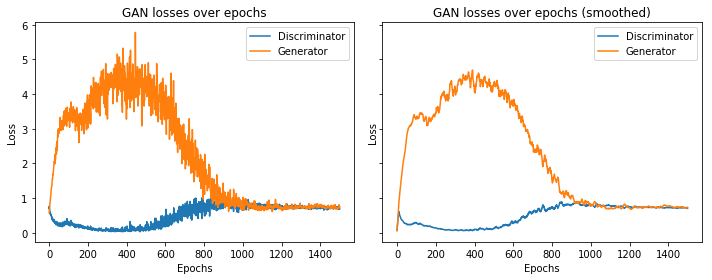

In [100]:
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True)
# fig.set_figheight(15)
fig.set_figwidth(10)

ax.plot(epochs, d_losses, label='Discriminator')
ax.plot(epochs, g_losses, label='Generator')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('GAN losses over epochs')
ax.legend()

from scipy.signal import lfilter

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,d_losses)
yy2 = lfilter(b,a,g_losses)

ax2.plot(epochs, yy, label='Discriminator')
ax2.plot(epochs, yy2, label='Generator')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('GAN losses over epochs (smoothed)')
ax2.legend()

fig.tight_layout()

fig.savefig("report/Figures/GAN_losses.pdf")

In [95]:
gan.discriminator.save("data/gan/D_params_keras2.p")
gan.generator.save("data/gan/G_params_keras2.p")

In [143]:
X_test2 = np.expand_dims(X_test, axis=3)

In [144]:
gan.discriminator.predict(X_test2).mean()

0.47819036

In [145]:
output = gan.discriminator.outputs[-1]
g

<tf.Tensor 'sequential_23/dense_80/Sigmoid:0' shape=(?, 1) dtype=float32>

In [196]:
loss = (1 - output) ** 2

In [197]:
# x = tf.placeholder(dtype=tf.float32, shape=(16,4,1))
grad = K.gradients(loss, gan.discriminator.inputs[-1])

In [198]:
input_tensors = [gan.discriminator.inputs[0]]

In [199]:
get_gradient = K.function(inputs=input_tensors, outputs=grad)

In [192]:
gan.discriminator.layers[0]

In [193]:
s = 0
for i in range(len(X_test2)):
    a = (gan.discriminator.predict(np.array([X_test2[i] - 0.5 * get_gradient([np.array([X_test2[i]])])[0][0]])) - 
          gan.discriminator.predict(np.array([X_test2[i]])))[0][0]
    print(a)
    s += a

0.017017484
0.014472812
0.02378577
0.03380263
0.020583868
0.036625117
0.050257266
0.028034687
0.04523343
0.04066685
0.03650242
0.03722176
0.011483073
0.0316751
0.03405395
-0.02336675
0.038393497
0.03227085
0.017562836
0.02953577
0.045758307
0.034379005
0.0287534
-0.005562842
0.024301052
0.038304865
0.012634218
0.03731799
0.0022512674
0.006965697
0.02485776
0.055334926
0.028143972
-0.0025057793
0.053590536
0.032235384
0.0021048188
0.041956723
0.041773528
0.033047765
0.060031027
0.052079678
-0.005211115
0.012318313
0.012152731
0.03998944
-0.066893965
0.034348637
0.046818435
0.05613807
-0.046607316
0.0335716
0.039328337
0.036933184
0.014288545
0.050610483
-0.005189687
-0.011988461
0.03986773
0.024558336
0.039340734
0.02846843
0.016751885
0.02925849
0.024647832
0.012912214
0.036672056
0.035764486
0.016476214
0.046866238
0.030190438
0.046842128
0.033991456
-0.03870529
0.034431666
0.015874386
0.022019744
0.04497105
0.01799202
0.013362795
0.03694412
0.05056089
-0.017667234
0.04147303
0.041442

In [194]:
s / len(X_test2)

0.026410871012715074

In [195]:
np.reshape(get_gradient([np.zeros((1,16,4,1))]), (16,4))

array([[ 0.04423181,  0.01414807,  0.08240975, -0.00649405],
       [-0.01023834, -0.00325331,  0.03351709,  0.02724741],
       [-0.01478089, -0.00975884,  0.04353722,  0.04251827],
       [ 0.05697052, -0.01438067, -0.01671395,  0.00209553],
       [ 0.03306558,  0.03985755, -0.00745412, -0.00408607],
       [ 0.03707616,  0.01980834,  0.04695232,  0.05842323],
       [-0.04199996,  0.01552188,  0.01165301,  0.03599345],
       [-0.01394785, -0.01775924, -0.00834355,  0.00183203],
       [ 0.05972204,  0.01455908,  0.02755802, -0.00555703],
       [ 0.01044734,  0.02486272,  0.00982277,  0.01443007],
       [ 0.06984463,  0.06265064,  0.06564831,  0.00397059],
       [-0.01385033, -0.04157392, -0.05063045, -0.01176556],
       [ 0.05849771,  0.06402914,  0.02157112,  0.03348415],
       [ 0.04250578,  0.07332051,  0.0176294 ,  0.07094444],
       [ 0.03808951,  0.02593835, -0.04495587,  0.06339164],
       [-0.02138552, -0.01906522,  0.05007151,  0.12491445]],
      dtype=float32)